This method explores the genre and rating associated with the movie and the customer to develop customer vector based on the content. The recommendations are generated using this customer vector.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

In [2]:
# Load movies data
movies = pd.read_csv('../0_data/input/movies.csv', converters={"genres": literal_eval})
ratings = pd.read_csv('../0_data/input/ratings.csv')

In [3]:
df = pd.merge(ratings, movies, on = 'tmdbId' , how = 'left')
df = df.drop('original_title', axis = 1)

In [4]:
# Split dataset
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df.userId)
train_data = train_data.sort_values(['userId', 'tmdbId'])
test_data = test_data.sort_values(['userId','tmdbId'])

In [5]:
# Load the training data
ratings_train = train_data.copy()
# ratings_train = pd.read_csv('../0_data/processed/training_data.csv', converters={"genres": literal_eval})

# ratings_train.head()

In [6]:
# Get unique genres from the data
unique_genre = movies['genres'].explode().unique()

# Make a dict assigning an index to a genre
genre_dict = {k: v for v, k in enumerate(unique_genre)}
genre_dict

{'Animation': 0,
 'Comedy': 1,
 'Family': 2,
 'Adventure': 3,
 'Fantasy': 4,
 'Romance': 5,
 'Drama': 6,
 'Action': 7,
 'Crime': 8,
 'Thriller': 9,
 'Horror': 10,
 'History': 11,
 'Science Fiction': 12,
 'Mystery': 13,
 'War': 14,
 'Foreign': 15,
 nan: 16,
 'Music': 17,
 'Documentary': 18,
 'Western': 19,
 'TV Movie': 20}

In [7]:
# Get the count of each genre

k = ratings_train['genres'].explode().value_counts().to_dict()
print(k)
genre_distribution = pd.DataFrame.from_dict(k, orient='index')
genre_distribution

{'Drama': 37694, 'Comedy': 28591, 'Action': 20598, 'Thriller': 20503, 'Adventure': 17476, 'Romance': 15041, 'Crime': 14079, 'Science Fiction': 12076, 'Fantasy': 10012, 'Family': 9485, 'Mystery': 7078, 'Horror': 4924, 'Animation': 4902, 'History': 3161, 'Music': 3109, 'War': 3042, 'Western': 1261, 'Documentary': 1157, 'Foreign': 169, 'TV Movie': 48}


,0
Drama,37694
Comedy,28591
Action,20598
Thriller,20503
Adventure,17476
Romance,15041
Crime,14079
Science Fiction,12076
Fantasy,10012
Family,9485


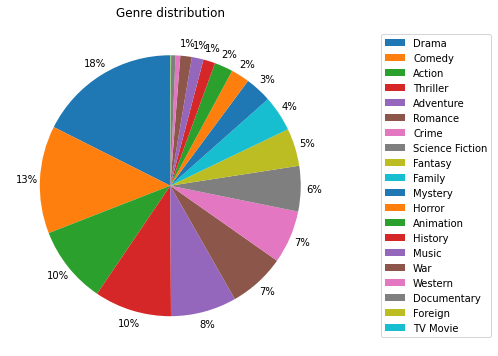

In [8]:
labelss = list(k.keys())
values = list(k.values())

def my_autopct(pct):
    return ('%.0f%%' % pct) if pct > 1 else ''

fig, ax = plt.subplots(figsize=(15, 6), subplot_kw=dict(aspect="equal"))

pie, texts, autotexts = ax.pie(values, startangle=90, autopct=my_autopct, pctdistance=1.1)

ax.legend(pie,
          labelss,
          bbox_to_anchor=(1, 0, 0.5, 1),
          loc="center right",
          fontsize=10)

plt.setp(autotexts, size=10)

ax.set_title("Genre distribution")

plt.show()

In [9]:
movies['movie_vector'] = ""
for ind, row in movies.iterrows():
    genres = row.genres
    movie_vector = np.zeros(len(genre_dict))

    for g in genres:
        movie_vector[genre_dict[g]] = 1
    movies.at[ind, 'movie_vector'] = movie_vector

# Save the final dataframe
movies.to_csv("../0_data/processed/movie_vector.csv")

In [10]:
movies.head()

,tmdbId,original_title,genres,movie_vector
0,862,Toy Story,"[Animation, Comedy, Family]","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,8844,Jumanji,"[Adventure, Fantasy, Family]","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,15602,Grumpier Old Men,"[Romance, Comedy]","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,31357,Waiting to Exhale,"[Comedy, Drama, Romance]","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
4,11862,Father of the Bride Part II,[Comedy],"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
user_ids = ratings_train['userId'].unique()
user_df = pd.DataFrame(columns=['userId', 'user_vector', 'avg_rating', 'num_movies_rated'])
                       
for user_id in user_ids:
#     print(user_id)
    user_rating_df = ratings_train[(ratings_train['userId'] == user_id)]
#     print(user_rating_df)

    user_vector = np.zeros(len(genre_dict))
    count_vector = np.zeros(len(genre_dict))
    
    user_avg_rating = 0
    movies_rated_count = 0
        
    for _, row in user_rating_df.iterrows():
        user_avg_rating += row.rating 
        movies_rated_count += 1
        genres = row.genres
        
        user_movie_vector = np.zeros(len(genre_dict))
        
        if genres:
            for g in genres:
                user_movie_vector[genre_dict[g]] = 1
                count_vector[genre_dict[g]] += 1
                        
        user_vector += user_movie_vector*row.rating

    count_vector = np.where(count_vector==0, 1, count_vector)
    user_vector = np.divide(user_vector, count_vector)
    user_avg_rating /= movies_rated_count
    row_df = pd.DataFrame([[user_id, user_vector, user_avg_rating, movies_rated_count]], 
                          columns=['userId', 'user_vector', 'avg_rating', 'num_movies_rated'])
#     print(row_df)
    user_df = pd.concat([user_df, row_df], ignore_index=True)

In [12]:
user_df

,userId,user_vector,avg_rating,num_movies_rated
0,1,"[1.5, 2.0, 1.5, 2.2, 1.0, 3.75, 2.583333333333...",2.593750,16
1,2,"[3.75, 3.0, 3.4545454545454546, 3.454545454545...",3.466667,60
2,3,"[2.8333333333333335, 3.4583333333333335, 3.071...",3.560976,41
3,4,"[4.7894736842105265, 4.416666666666667, 4.8, 4...",4.368098,163
4,5,"[3.9, 3.988095238095238, 3.9722222222222223, 3...",3.956250,80
...,...,...,...,...
666,667,"[4.0, 3.8095238095238093, 4.0, 3.2222222222222...",3.666667,54
667,668,"[3.0, 2.5, 3.0, 3.3333333333333335, 3.0, 0.0, ...",3.733333,15
668,669,"[0.0, 3.076923076923077, 0.0, 4.0, 2.666666666...",3.233333,30
669,670,"[4.0, 3.7142857142857144, 4.0, 3.6666666666666...",3.920000,25


In [13]:
# Save the final dataframe
user_df.to_csv("../0_data/processed/user_info.csv")

In [14]:
user_df.head()

,userId,user_vector,avg_rating,num_movies_rated
0,1,"[1.5, 2.0, 1.5, 2.2, 1.0, 3.75, 2.583333333333...",2.593750,16
1,2,"[3.75, 3.0, 3.4545454545454546, 3.454545454545...",3.466667,60
2,3,"[2.8333333333333335, 3.4583333333333335, 3.071...",3.560976,41
3,4,"[4.7894736842105265, 4.416666666666667, 4.8, 4...",4.368098,163
4,5,"[3.9, 3.988095238095238, 3.9722222222222223, 3...",3.956250,80


In [15]:
ratings_test = test_data.copy()
ratings_test.head()

,userId,tmdbId,rating,timestamp,genres
442,1,152,2.5,1260759135,"[Science Fiction, Adventure, Mystery]"
305,1,783,2.0,1260759148,"[Drama, History]"
117,1,1103,2.0,1260759185,"[Science Fiction, Action]"
42,1,11360,3.0,1260759179,"[Animation, Family]"
4476,2,13,3.0,835355628,"[Comedy, Drama, Romance]"


### Next  few cells for sample test data point

In [16]:
ratings_test.iloc[0]

userId                                           1
tmdbId                                         152
rating                                         2.5
timestamp                               1260759135
genres       [Science Fiction, Adventure, Mystery]
Name: 442, dtype: object

In [17]:
user_rating_df[user_rating_df['tmdbId']==14]

,userId,tmdbId,rating,timestamp,genres
11634,671,14,4.0,1063503841,[Drama]


In [18]:
genres = user_rating_df[user_rating_df['tmdbId']==14].genres.values[0]
vector = np.zeros(len(genre_dict))
for g in genres:
    vector[genre_dict[g]] = 1
print(vector)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [19]:
user_df[user_df['userId']==1].user_vector[0]

array([1.5       , 2.        , 1.5       , 2.2       , 1.        ,
       3.75      , 2.58333333, 3.        , 2.875     , 3.        ,
       3.        , 2.        , 2.5       , 0.        , 2.        ,
       0.        , 0.        , 0.        , 0.        , 3.        ,
       0.        ])

In [20]:
x = vector*user_df[user_df['userId']==1].user_vector[0]
np.nanmean(np.where(x!=0,x,np.nan)) 

2.5833333333333335

### Test on entire test data

In [21]:
# Load the already calculated data from csvs

# user_df = pd.read_csv("../0_data/processed/user_info.csv", converters={"user_vector": pd.array})
# movies_df = pd.read_csv("../0_data/processed/movie_vector.csv", converters={"movie_vector": pd.array})

In [50]:
algo_predictions = pd.DataFrame(columns=['userId', 'tmdbId', 'user_vector', 'movie_vector', 'og_rating', 'pred_rating'])

start_test = time.time()
for ind, row in ratings_test.iterrows():
    userId = row['userId']
    tmdbId = row['tmdbId']
    og_rating = row['rating']
    
    try:
        user_vector = user_df[user_df['userId'] == int(userId)].user_vector.values[0]
        movie_vector = movies[movies['tmdbId'] == int(tmdbId)].movie_vector.values[0]

        predicted_rating = user_vector*movie_vector
        
        if predicted_rating.any():
            predicted_rating = np.nanmean(np.where(predicted_rating!=0, predicted_rating, np.nan)) 
        else:
            predicted_rating = 0

        row_df = pd.DataFrame([[userId, tmdbId, user_vector, movie_vector, og_rating, predicted_rating]], 
                    columns=['userId', 'tmdbId', 'user_vector', 'movie_vector', 'og_rating', 'pred_rating'])
        algo_predictions = pd.concat([algo_predictions, row_df], ignore_index=True)
    except:
        print("User not found: ", userId)
        
#     print(ind, row['userId'])
    
end_test = time.time()
test_time = end_test - start_test

In [51]:
test_time

60.32719087600708

In [52]:
rmse = ((algo_predictions.og_rating - algo_predictions.pred_rating) ** 2).mean() ** .5
rmse

0.9511887757824071

In [53]:
mae = (((algo_predictions.og_rating - algo_predictions.pred_rating) ** 2) ** .5).mean()
mae

0.7349830220178154

In [54]:
algo_predictions

,userId,tmdbId,user_vector,movie_vector,og_rating,pred_rating
0,1,152,"[1.5, 2.0, 1.5, 2.2, 1.0, 3.75, 2.583333333333...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.5,2.350000
1,1,783,"[1.5, 2.0, 1.5, 2.2, 1.0, 3.75, 2.583333333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",2.0,2.291667
2,1,1103,"[1.5, 2.0, 1.5, 2.2, 1.0, 3.75, 2.583333333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",2.0,2.750000
3,1,11360,"[1.5, 2.0, 1.5, 2.2, 1.0, 3.75, 2.583333333333...","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,1.500000
4,2,13,"[3.75, 3.0, 3.4545454545454546, 3.454545454545...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",3.0,3.413603
...,...,...,...,...,...,...
19965,671,11072,"[4.428571428571429, 3.9838709677419355, 4.1666...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,3.804435
19966,671,11153,"[4.428571428571429, 3.9838709677419355, 4.1666...","[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",3.5,4.012895
19967,671,11663,"[4.428571428571429, 3.9838709677419355, 4.1666...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",4.0,3.773609
19968,671,14291,"[4.428571428571429, 3.9838709677419355, 4.1666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",4.0,3.836957


In [55]:
algo_predictions_repurposed = algo_predictions[['userId', 'tmdbId', 'og_rating', 'pred_rating']]

In [56]:
algo_predictions_repurposed

,userId,tmdbId,og_rating,pred_rating
0,1,152,2.5,2.350000
1,1,783,2.0,2.291667
2,1,1103,2.0,2.750000
3,1,11360,3.0,1.500000
4,2,13,3.0,3.413603
...,...,...,...,...
19965,671,11072,3.0,3.804435
19966,671,11153,3.5,4.012895
19967,671,11663,4.0,3.773609
19968,671,14291,4.0,3.836957


In [57]:
import math
from collections import defaultdict
import csv
from sklearn.metrics import ndcg_score
import time
from surprise.prediction_algorithms.predictions import Prediction

In [58]:
predictions = [Prediction(uid=x, iid=y, r_ui=z, est=t, details = {}) for x, y, z, t in zip(algo_predictions_repurposed['userId'], algo_predictions_repurposed['tmdbId'], algo_predictions_repurposed['og_rating'], algo_predictions_repurposed['pred_rating'])]

In [59]:
predictions

[Prediction(uid=1, iid=152, r_ui=2.5, est=2.35, details={}),
 Prediction(uid=1, iid=783, r_ui=2.0, est=2.291666666666667, details={}),
 Prediction(uid=1, iid=1103, r_ui=2.0, est=2.75, details={}),
 Prediction(uid=1, iid=11360, r_ui=3.0, est=1.5, details={}),
 Prediction(uid=2, iid=13, r_ui=3.0, est=3.4136029411764706, details={}),
 Prediction(uid=2, iid=629, r_ui=4.0, est=3.2959558823529407, details={}),
 Prediction(uid=2, iid=712, r_ui=3.0, est=3.4136029411764706, details={}),
 Prediction(uid=2, iid=1245, r_ui=4.0, est=3.6204044117647056, details={}),
 Prediction(uid=2, iid=2758, r_ui=3.0, est=3.2515151515151515, details={}),
 Prediction(uid=2, iid=4476, r_ui=5.0, est=3.6738385695187166, details={}),
 Prediction(uid=2, iid=6520, r_ui=3.0, est=3.5120738636363638, details={}),
 Prediction(uid=2, iid=8587, r_ui=3.0, est=3.5994318181818183, details={}),
 Prediction(uid=2, iid=9603, r_ui=5.0, est=3.4136029411764706, details={}),
 Prediction(uid=2, iid=11318, r_ui=3.0, est=3.420138888888889

In [60]:
def get_top_n(predictions, n):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    org_ratings = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        org_ratings[uid].append((iid, true_r))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n, org_ratings

In [61]:
def dcg_at_k(scores):
    return scores[0] + sum(sc/math.log(ind, 2) for sc, ind in zip(scores[1:], range(2, len(scores) + 1)))

def ndcg_at_k(scores):
    idcg = dcg_at_k(sorted(scores, reverse=True))
    return (dcg_at_k(scores)/idcg) if idcg > 0.0 else 0.0

In [62]:
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    precision = (sum(prec for prec in precisions.values()) / len(precisions))
    recall = (sum(rec for rec in recalls.values()) / len(recalls))

    return precision, recall

In [63]:
top_n, org_ratings = get_top_n(predictions, 5)

precision, recall = precision_recall_at_k(predictions)

f_measure = (2*precision*recall)/(precision+recall)

ndcg_scores = dict()
for uid, user_ratings in top_n.items():
    scores = []
    for iid, est_r in user_ratings:
        iid_found = False
        org_user_ratings = org_ratings[uid]
        for i, r in org_user_ratings:
            if iid == i:
                scores.append(r)
                iid_found = True
                break
        if not iid_found:
            scores.append(0)
ndcg_scores[uid] = ndcg_at_k(scores)
ndcg_score = sum(ndcg for ndcg in ndcg_scores.values())/len(ndcg_scores)

In [64]:
top_n

defaultdict(list,
            {1: [(1103, 2.75),
              (152, 2.35),
              (783, 2.291666666666667),
              (11360, 1.5)],
             2: [(4476, 3.6738385695187166),
              (11450, 3.630208333333333),
              (1245, 3.6204044117647056),
              (8587, 3.5994318181818183),
              (6520, 3.5120738636363638)],
             3: [(857, 3.8125),
              (1251, 3.625),
              (13, 3.600198412698413),
              (1892, 3.465277777777778),
              (1024, 3.447916666666667)],
             4: [(10957, 4.7894736842105265),
              (10882, 4.717027863777091),
              (10693, 4.657099345239137),
              (2758, 4.621241830065359),
              (15944, 4.608333333333333)],
             5: [(2024, 4.27435064935065),
              (423, 4.2272727272727275),
              (621, 4.125),
              (1597, 4.056547619047619),
              (15602, 4.056547619047619)],
             6: [(846, 3.523809523809524),
     

In [65]:
print('Precision: ', precision)
print('Recall: ', recall)
print('F Measure: ', f_measure)
print('NDCG: ', ndcg_score)

Precision:  0.8057128663686057
Recall:  0.361555863603943
F Measure:  0.4991313546514015
NDCG:  0.992242282421014
